<a href="https://colab.research.google.com/github/sandrabinu3/LLM-BERT/blob/main/Multi_Class_Sentiment_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multi-Class Sentiment Analysis using BERT

####Install and Import the required libraries

In [ ]:
!pip install -U datasets

In [ ]:
!pip install transformers datasets evaluate

  Using cached evaluate-0.4.4-py3-none-any.whl.metadata (9.5 kB)
Using cached evaluate-0.4.4-py3-none-any.whl (84 kB)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict
from collections import defaultdict
import random
import re
from datasets import Dataset
from transformers import AutoTokenizer, BertConfig
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from transformers import DataCollatorWithPadding
import evaluate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


###Load the Yelp Dataset

In [ ]:
dataset = load_dataset("Yelp/yelp_review_full")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

##EDA

In [ ]:
print(dataset["train"]['label'])


Column([4, 1, 3, 3, 0])


In [ ]:
print(dataset["test"]['label'])


Column([0, 0, 0, 0, 0])


In [ ]:
from collections import Counter
print(Counter(dataset["test"]['label']))

Counter({0: 10000, 2: 10000, 1: 10000, 3: 10000, 4: 10000})


In [ ]:
print(Counter(dataset["train"]['label']))

Counter({4: 130000, 1: 130000, 3: 130000, 0: 130000, 2: 130000})


##Data Preprocessing

In [ ]:
def clean_text(text):
    text = text.strip()
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"\s+", " ", text)  # Replace multiple spaces with one
    return text


In [ ]:
# Clean text
def preprocess_function(example):
    example["text"] = clean_text(example["text"])
    return example

train_dataset = dataset["train"].map(preprocess_function)

Map:   0%|          | 0/650000 [00:00<?, ? examples/s]

In [ ]:
test_dataset = dataset["test"].map(preprocess_function)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

# Apply tokenizer
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test =test_dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/650000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_train[0].keys())

dict_keys(['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'])


In [ ]:
# Combine into a DatasetDict
tokenized_datasets = DatasetDict({
    "train": tokenized_train,
    "test": tokenized_test})

##Model Configuration and Training

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=5, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", config=config)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=predictions, references=labels, average="macro")["f1"]}

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch", # Add save_strategy and set to epoch
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True, # Load the best model when training ends
    metric_for_best_model="eval_accuracy", # Metric to monitor for early stopping
    )


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"].shuffle(seed=42).select(range(10000)),  # Subset for speed
    eval_dataset=tokenized_datasets["test"].shuffle(seed=42).select(range(1000)),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,)

/tmp/ipython-input-22-3754243717.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.031600,0.918902,0.613000,0.614174


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.031600,0.918902,0.613000,0.614174
2,0.757900,0.861831,0.636000,0.637763
3,0.692000,0.877564,0.635000,0.636862


TrainOutput(global_step=3750, training_loss=0.8851386540730795, metrics={'train_runtime': 968.6615, 'train_samples_per_second': 30.971, 'train_steps_per_second': 3.871, 'total_flos': 7893544273920000.0, 'train_loss': 0.8851386540730795, 'epoch': 3.0})

##Evaluation of results

In [ ]:
results = trainer.evaluate()
print(results)


{'eval_loss': 0.8618306517601013, 'eval_accuracy': 0.636, 'eval_f1_macro': 0.6377633878948598, 'eval_runtime': 14.4849, 'eval_samples_per_second': 69.037, 'eval_steps_per_second': 8.63, 'epoch': 3.0}


In [ ]:
import numpy as np
print("Unique true labels in selected test subset:", np.unique(y_true))
print("Unique predicted labels in selected test subset:", np.unique(y_pred))

Unique true labels in selected test subset: [0 1 2 3 4]
Unique predicted labels in selected test subset: [0 1 2 3 4]


In [ ]:
text1 = "The food was excellent, but the service was really slow."
inputs = tokenizer(text1, return_tensors="pt", truncation=True, padding=True)
inputs = {k: v.to(model.device) for k, v in inputs.items()} # Move inputs to the model's device
outputs = model(**inputs)
predicted_class = outputs.logits.argmax(dim=-1).item()
print(f"Predicted Star Rating: {predicted_class + 1} stars")

Predicted Star Rating: 3 stars


In [ ]:
text2 = "Shop ambience was okay but food was terrible, so unsatisfied"
inputs = tokenizer(text2, return_tensors="pt", truncation=True, padding=True)
inputs = {k: v.to(model.device) for k, v in inputs.items()}
outputs = model(**inputs)
predicted_class = outputs.logits.argmax(dim=-1).item()
print(f"Predicted Star Rating: {predicted_class + 1} stars")

Predicted Star Rating: 2 stars


In [ ]:
text3 = "Great experience, will suggest to my friends!"
inputs = tokenizer(text3, return_tensors="pt", truncation=True, padding=True)
inputs = {k: v.to(model.device) for k, v in inputs.items()}
outputs = model(**inputs)
predicted_class = outputs.logits.argmax(dim=-1).item()
print(f"Predicted Star Rating: {predicted_class + 1} stars")

Predicted Star Rating: 5 stars


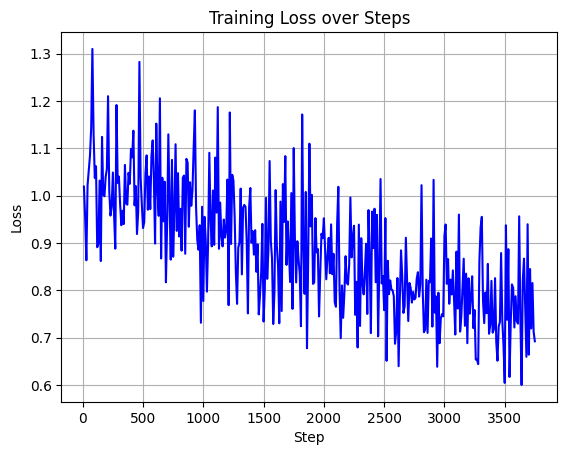

In [ ]:
# Use `trainer.state.log_history` if logging_steps is enabled
logs = pd.DataFrame(trainer.state.log_history)

# Filter for loss only
loss_logs = logs[logs['loss'].notnull()]

plt.plot(loss_logs["step"], loss_logs["loss"], label="Training Loss", color="blue")
plt.title("Training Loss over Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


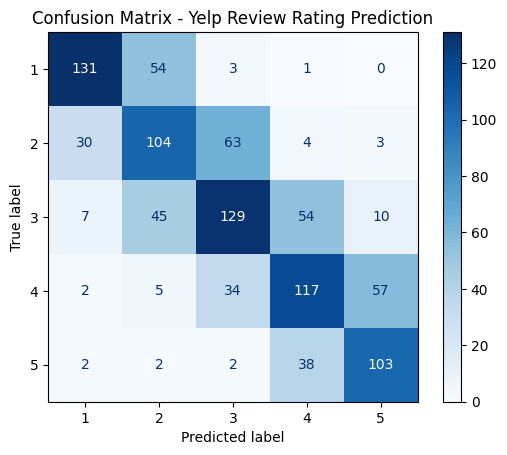

In [ ]:

# Get predictions
predictions = trainer.predict(tokenized_datasets["test"].select(range(1000)))
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Yelp Review Rating Prediction")
plt.show()


In [ ]:

sample_indices = [10, 25, 77]
for idx in sample_indices:
    review_text = dataset["test"][idx]["text"]
    true_label = dataset["test"][idx]["label"]

    inputs = tokenizer(review_text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()} # Move inputs to the model's device
    outputs = model(**inputs)
    pred_label = outputs.logits.argmax(dim=-1).item()

    print(f"Review: {review_text[:150]}...")
    print(f"True Rating: {true_label + 1}, Predicted: {pred_label + 1}")
    print("-" * 80)

Review: Think Chuck E. Cheese for adults.  Skee Ball, video games pool tables.  Clean environment.  Good fun.\n\nUnfortunately, I went for a bite to eat and i...
True Rating: 2, Predicted: 2
--------------------------------------------------------------------------------
Review: I hate this place.\nIt's very loud, the service is very poor, and the food is so-so.\nIf you want good Chinese in Pittsburgh, try China Palace (Shadys...
True Rating: 1, Predicted: 1
--------------------------------------------------------------------------------
Review: OK so another winner in this neighborhood besides Nicky's.  The Penna Parma was outstanding and the Parm crusted salmon over whole wheat artichoke rav...
True Rating: 5, Predicted: 4
--------------------------------------------------------------------------------


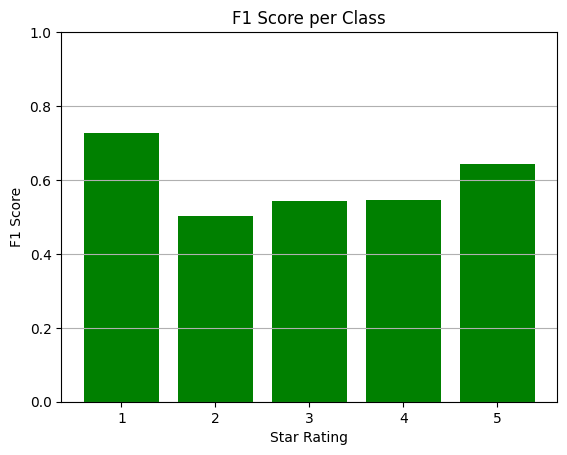

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, output_dict=True)
f1_scores = [report[str(i)]['f1-score'] for i in range(5)]

plt.bar([1, 2, 3, 4, 5], f1_scores, color='green')
plt.title("F1 Score per Class")
plt.xlabel("Star Rating")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


In [35]:
history = trainer.state.log_history
metrics = defaultdict(list)

for entry in history:
    if "epoch" in entry:
        # Only append metrics for entries that have evaluation results (end of epoch)
        if "eval_loss" in entry:
            metrics["epoch"].append(entry["epoch"])
            metrics["val_loss"].append(entry["eval_loss"])
            metrics["val_accuracy"].append(entry["eval_accuracy"])
            metrics["val_f1"].append(entry["eval_f1_macro"])
            # Find the corresponding training loss at the end of the epoch
            for train_entry in history:
                if train_entry.get("epoch") == entry["epoch"] and "loss" in train_entry and "eval_loss" not in train_entry:
                    metrics["train_loss"].append(train_entry["loss"])
                    break

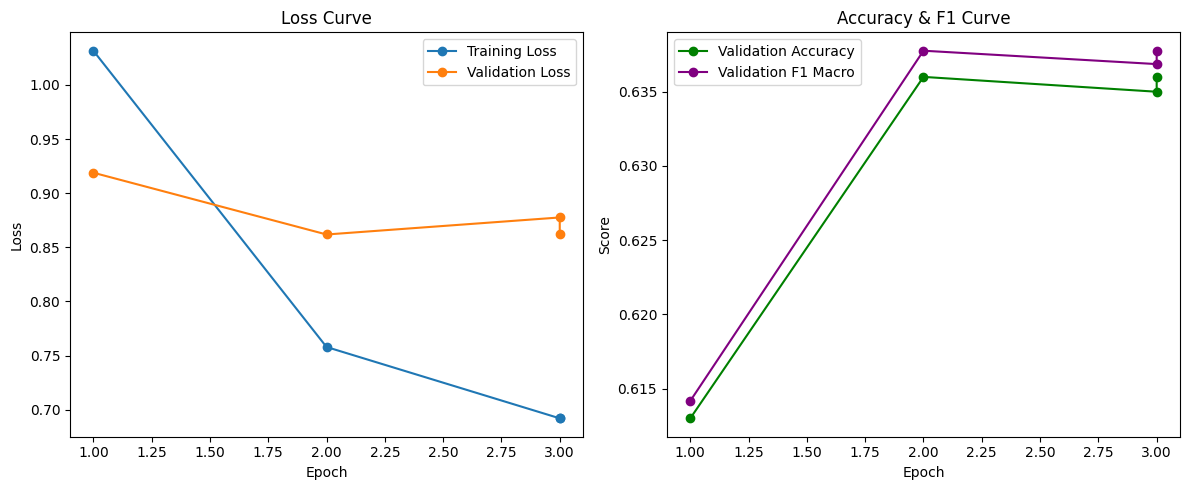

In [38]:
# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['epoch'], metrics['train_loss'], label='Training Loss', marker='o')
plt.plot(metrics['epoch'], metrics['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(metrics['epoch'], metrics['val_accuracy'], label='Validation Accuracy', marker='o', color='green')
plt.plot(metrics['epoch'], metrics['val_f1'], label='Validation F1 Macro', marker='o', color='purple')
plt.title('Accuracy & F1 Curve')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()